In [1]:
# Add noise to the simulated light curves
# By add noise from Kepler Dataset
# Here std dev <0.01 is considered
# Kepler_noise_addn_v1.ipynb


# In other versions more refined std_dev will be considered

# Initial import and normalization

In [1]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
from sklearn.model_selection import train_test_split
import sys
import random 

2023-09-19 14:55:45.478275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 14:55:46.419064: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [3]:
# 1. Load Dataset
## Load Train Set
train_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled5.npy'
train_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_5.npy'
train_lc = np.load(train_lc_dir)
train_shape = np.load(train_shape_dir)
# Check equality of number of dataset
if len(train_lc)==len(train_shape):
    print("Train Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: Train Set: No. of LC != No. of shapes")

## Load Validation Set
vald_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled4.npy'
vald_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_4.npy'
vald_lc = np.load(vald_lc_dir)
vald_shape = np.load(vald_shape_dir)
# Check equality of nuftmber of dataset
if len(vald_lc)==len(vald_shape):
    print("Vald Set: No. of LC = No. of shapes")
else:
    sys.exit("Vald Set: No. of LC = No. of shapes")

Train Set: No. of LC = No. of shapes
Vald Set: No. of LC = No. of shapes


In [4]:
# 2. Normalize the image, convert to opacity map
## Train Set
train_shape = train_shape/np.amax(train_shape)
train_shape_where_0 = np.where(train_shape == 0)
train_shape_where_1 = np.where(train_shape == 1)
train_shape[train_shape_where_0] = 1  # 1 represent the shape (1 opacity)
train_shape[train_shape_where_1] = 0  # 0 represent background (0 opacity)

## Valdn Set
vald_shape = vald_shape/np.amax(vald_shape)
vald_shape_where_0 = np.where(vald_shape == 0)
vald_shape_where_1 = np.where(vald_shape == 1)
vald_shape[vald_shape_where_0] = 1  # 1 represent the shape (1 opacity)
vald_shape[vald_shape_where_1] = 0  # 0 represent background (0 opacity)
print("Normalized the shape")


Normalized the shape


In [5]:
# 2. Normalize the lightcurves
## - Train Set
train_lc_scaled = np.zeros(train_lc.shape)
for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled[i] = (train_lc[i] - np.amin(train_lc[i]))/(np.amax(train_lc[i]) - np.amin(train_lc[i]))

## - Vald Set
vald_lc_scaled = np.zeros(vald_lc.shape)
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled[i] = (vald_lc[i] - np.amin(vald_lc[i]))/(np.amax(vald_lc[i]) - np.amin(vald_lc[i]))
print("Normalized the light curves")


Normalized the light curves


In [6]:
# Add flat line towards left and right of dip
# 10 data points on each side
# 3. Extend the lightcurves
## - Train Set
train_lc_scaled_append = np.ones((train_lc.shape[0],120))
print('train_lc_scaled_append.shape = ',train_lc_scaled_append.shape)
print("len(train_lc_scaled_append[0,10:110]) = ",len(train_lc_scaled_append[0,10:110]))

for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled_append[i,10:110] = train_lc_scaled[i]

## - Vald Set
vald_lc_scaled_append = np.ones((vald_lc.shape[0],120))
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled_append[i,10:110] = vald_lc_scaled[i]
print("Extended the light curves")

train_lc_scaled_append.shape =  (132136, 120)
len(train_lc_scaled_append[0,10:110]) =  100
Extended the light curves


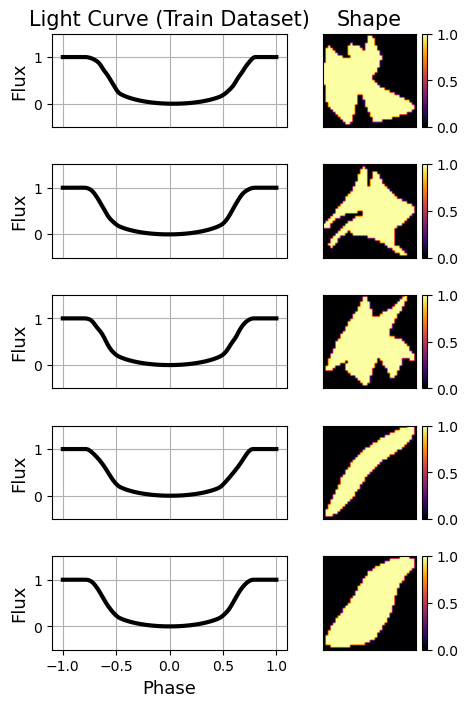

In [7]:
# Verification
# Plot - Train LCs
num = 5
fig,ax=plt.subplots(num,2, figsize=(5,8), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (Train Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(train_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(train_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(train_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, train_lc_scaled_append[k],color = 'black',linewidth='3')
    ax[i][0].grid('on')
    i = i + 1

# Load Kepler noise

In [2]:
filenames = ['/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00000-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00001-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00002-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00003-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00004-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00005-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00006-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00007-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/val-00000-of-00001',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/test-00000-of-00001']
raw_dataset = tf.data.TFRecordDataset(filenames)
# raw_dataset

feature_description = {
    'global_view': tf.io.FixedLenSequenceFeature([], tf.float32, default_value=0.0,allow_missing=True),
    'local_view': tf.io.FixedLenSequenceFeature([], tf.float32, default_value=0.0,allow_missing=True),
    'av_training_set': tf.io.FixedLenFeature([], tf.string, default_value=''),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

# At this point the dataset contains serialized tf.train.Example messages.
# When iterated over it returns these as scalar string tensors.
# Use the .take method to only show the first 10 records.
for raw_record in raw_dataset.take(10):
  print(repr(raw_record))
  
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset


<tf.Tensor: shape=(), dtype=string, numpy=b'\n\xdbG\n\x15\n\x0ctce_plnt_num\x12\x05\x1a\x03\n\x01\x02\n\x19\n\x0fav_training_set\x12\x06\n\x04\n\x02PC\n\x1b\n\x0ftce_max_mult_ev\x12\x08\x12\x06\n\x04H\xe1\x06B\n\x1a\n\x0espline_bkspace\x12\x08\x12\x06\n\x04\x9a\xa97@\n\x17\n\rav_pred_class\x12\x06\n\x04\n\x02PC\n\x15\n\ttce_depth\x12\x08\x12\x06\n\x043\x13PD\n\x16\n\ntce_impact\x12\x08\x12\x06\n\x04\x94\xf66?\n\x19\n\rtce_model_snr\x12\x08\x12\x06\n\x04\x14\xae\x02B\n\x14\n\x08tce_prad\x12\x08\x12\x06\n\x04\xecQ@@\n\x17\n\x0btce_time0bk\x12\x08\x12\x06\n\x04\x17\x193C\n\xda>\n\x0bglobal_view\x12\xca>\x12\xc7>\n\xc4>\x8a\x99\xbc<\xde\x8f\x9c\xbdl\xf5l<(s\r=o\x1f\xe8\xba\t\xcf\xbd\xbcG\n\xc2\xbc"\x1f\x17\xbc\xfd&\xd1\xbc\x15w*=f\xa1v\xbc\xea\x95\xf0\xbci\xcb\xf1<\x00\x00\x00\x00g6t\xbd\x1f\xf5\x9b=\xabg\x87<]\xc5\x1d=.\xc7\x83<\\0\xa0\xbd\xb0&\x00>\x98\xd6\xa6<\x96A)\xbcb\x84\x96\xbd\xb6)\xaa\xbd)\x08\x8b\xbc\x1c\x1cm>\xab\x16\xbb=}\\R=\xf3\x13b\xbc\x02\xe6\xc9\xbdg6t\xbd\x93\x17\xae\xbc

2023-09-19 14:56:06.759842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16055 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-09-19 14:56:07.287334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


<_MapDataset element_spec={'av_training_set': TensorSpec(shape=(), dtype=tf.string, name=None), 'global_view': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'local_view': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}>

In [3]:
# Calculate the size of one light curve corresponding to 'local_view'
y = np.array([])
for elem in parsed_dataset.take(1):
  y = np.append(y,[elem['local_view']])
length_lc = len(y)
print("length_lc = " ,length_lc)


# Calculate total number of light curves
no_data = 0
for elem in parsed_dataset.as_numpy_iterator():
    no_data = no_data + 1
print('no_data = ',no_data)

# convert all tf dataset to np array (light curve numpy array (lc_np_array))
lc_np_array = np.zeros(shape=(no_data,length_lc))
lc_np_array.shape


i = 0
for elem in parsed_dataset.as_numpy_iterator():
    lc_np_array[i] = elem['local_view'] #+1.0
    i = i + 1

print('lc_np_array[0] = ',lc_np_array[0])


2023-09-19 14:56:10.695426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]
2023-09-19 14:56:10.733995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


length_lc =  201
no_data =  15737
lc_np_array[0] =  [-6.92397356e-02 -2.56392676e-02 -4.75080535e-02 -6.34126291e-02
 -2.86556520e-02 -7.22561181e-02 -7.22561181e-02  1.56303551e-02
  3.60595062e-02  5.99163622e-02  5.51175699e-02 -4.38746847e-02
  6.16987748e-03  4.48344424e-02  2.11146921e-02  1.93322822e-02
  4.11325163e-04 -4.53828759e-02 -5.10728732e-02 -5.02502210e-02
 -3.57852876e-02 -9.18626133e-03  3.29060107e-02  5.47062457e-02
 -7.54096126e-03  1.37108378e-04  2.26228833e-02  2.57763769e-02
  1.12977311e-01  9.85809267e-02  7.41756335e-02  3.29060107e-02
 -7.87687674e-02  2.42681839e-02  1.53561393e-02  8.08939431e-03
 -1.70014389e-02 -8.80235806e-02 -7.41756335e-02 -7.97970816e-02
 -5.81339560e-02 -2.64619179e-02 -3.08493860e-02  2.33084261e-02
 -3.53739634e-02 -3.53739634e-02  1.37108390e-03  1.09686712e-02
 -1.68643314e-02  1.72756556e-02  1.87838487e-02  1.87838487e-02
  2.60505918e-03  6.95139542e-02 -4.53828759e-02 -6.64975643e-02
  6.71831099e-03 -4.66168523e-02 -2.87

len(ph) =  201
len(ph[0:60]) =  60


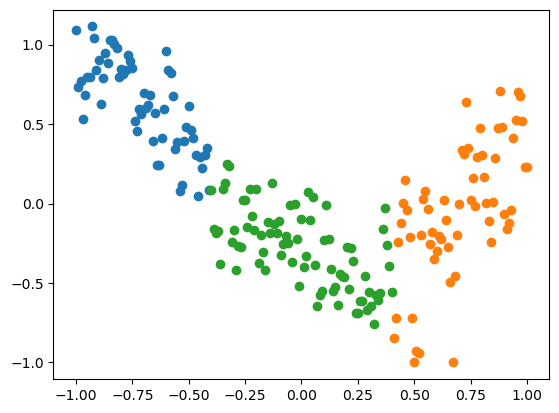

In [4]:
# Verification of loading Kepler Dataset
for i in np.arange(1):
    i=8970
    test_lc = lc_np_array[i]

    ph = np.linspace(-1.0,1.0,len(lc_np_array[0]))
    print('len(ph) = ',len(ph))
    plt.scatter(ph[0:60], test_lc[0:60])
    print('len(ph[0:60]) = ',len(ph[0:60]))
    plt.scatter(ph[141:202], test_lc[141:202])
    # print('len(ph[141:202]) = ',len(ph[141:202]))
    plt.scatter(ph[60:141], test_lc[60:141])

    plt.show()

len(ph) =  120
noise_array.shape =  (15737, 120)


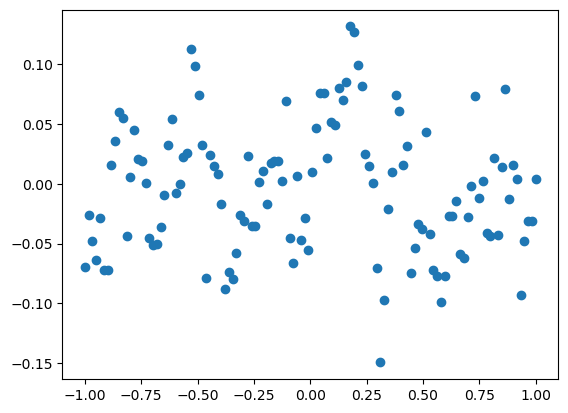

In [5]:
# Noise Array
# Append first 60 and last 60 elements
noise_array = np.zeros((len(lc_np_array),120))
for i in np.arange(len(lc_np_array)):
    noise_array[i][0:60] = lc_np_array[i,0:60]
    noise_array[i][60:120] = lc_np_array[i,141:202]


ph = np.linspace(-1.0,1.0,len(noise_array[0]))
plt.scatter(ph, noise_array[0])
print('len(ph) = ',len(ph))
print('noise_array.shape = ',noise_array.shape)

plt.show()

a =  [1960  695  767  698  628  649  601  564  485  396  319  288  246  262
  339  337  439  486  560  569  524  533  487  415  380  340  279  259
  190  167  156   94   83   77   50   50   36   34   26   17   24   23
   19   10   11   15   13    5    5   14    9   10    9    5    6    2
    5    4    7    4    1    2    2    2    2    4    1    2    1    0
    0    4    1    1    2    2    4    2    0    1    0    2    3    0
    1    0    0    0    1    0    1    2    1    0    0    0    0    0
    0]
a_percent =  [1.24602670e+01 4.41830896e+00 4.87603306e+00 4.43738080e+00
 3.99237127e+00 4.12587413e+00 3.82072473e+00 3.58550540e+00
 3.08328036e+00 2.51748252e+00 2.02797203e+00 1.83089638e+00
 1.56389065e+00 1.66560712e+00 2.15511761e+00 2.14240305e+00
 2.79084552e+00 3.08963764e+00 3.56007629e+00 3.61729180e+00
 3.33121424e+00 3.38842975e+00 3.09599491e+00 2.63827082e+00
 2.41576605e+00 2.16147489e+00 1.77368086e+00 1.64653528e+00
 1.20788303e+00 1.06166561e+00 9.91735537e-01 5.975

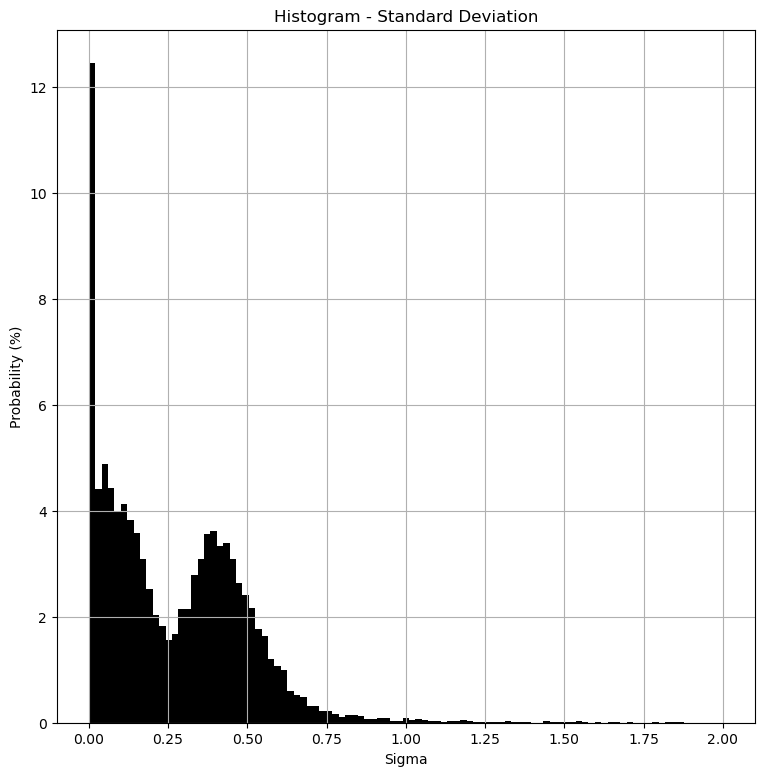

In [6]:
# Calc std dev of the arrays
std_devs_Kepler = np.array([np.std(arr) for arr in noise_array])

# Plot histogram of std dev
# bins = np.logspace(-5,5,100)
# bins = np.linspace(0,10**2,11)
bins = np.linspace(0,2,100)

plt.figure(figsize=(9, 9))
# plt.hist(std_devs_Kepler, bins=bins, density=True, alpha=0.8, color='tab:green')
a,*_ = np.histogram(std_devs_Kepler, bins=bins)
print('a = ',a)
a_percent = (a/np.sum(a))*100
print('a_percent = ',a_percent)

plt.stairs(a_percent, bins, baseline=0,fill=True,color='black')
plt.xlabel('Sigma')
# plt.xscale("log")
plt.ylabel('Probability (%)')
plt.title('Histogram - Standard Deviation')
plt.grid(True)
plt.show()

np.sum(a) =  15617


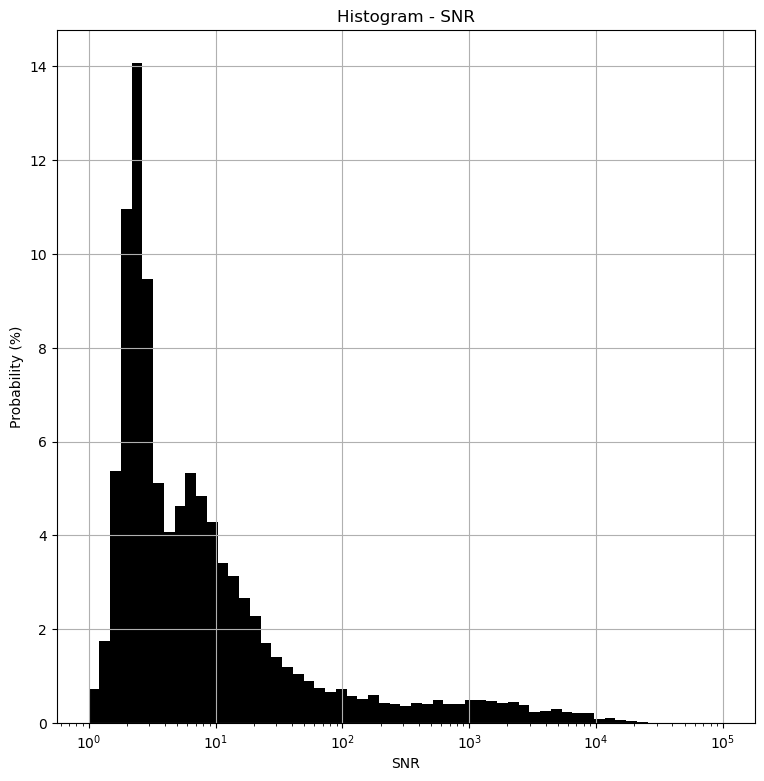

In [10]:
# Calc SNR of the arrays
SNR_kepler = 1/std_devs_Kepler

# Plot histogram of std dev
# bins = np.logspace(-5,5,100)
# bins = np.linspace(0,10**2,11)
bins = np.logspace(0,5,60)

plt.figure(figsize=(9, 9))
# plt.hist(std_devs_Kepler, bins=bins, density=True, alpha=0.8, color='tab:green')
a,*_ = np.histogram(SNR_kepler, bins=bins)
# print('a = ',a)
print('np.sum(a) = ', np.sum(a))
a_percent = (a/np.sum(a))*100
# print('a_percent = ',a_percent)

plt.stairs(a_percent, bins, baseline=0,fill=True,color='black')
plt.xlabel('SNR')
plt.xscale("log")
plt.ylabel('Probability (%)')
plt.title('Histogram - SNR')
plt.grid(True)
plt.show()

# Select Kepler light curves with std dev < 0.01

[0.00166543 0.00622578 0.00061769 ... 0.0004054  0.00193507 0.00301132]
a =  [437 254 136 101  82  51  49  46  45  37  44  40  28  32  37  29  29  26
  27]
a_percent =  [28.5620915  16.60130719  8.88888889  6.60130719  5.35947712  3.33333333
  3.20261438  3.00653595  2.94117647  2.41830065  2.87581699  2.61437908
  1.83006536  2.09150327  2.41830065  1.89542484  1.89542484  1.69934641
  1.76470588]


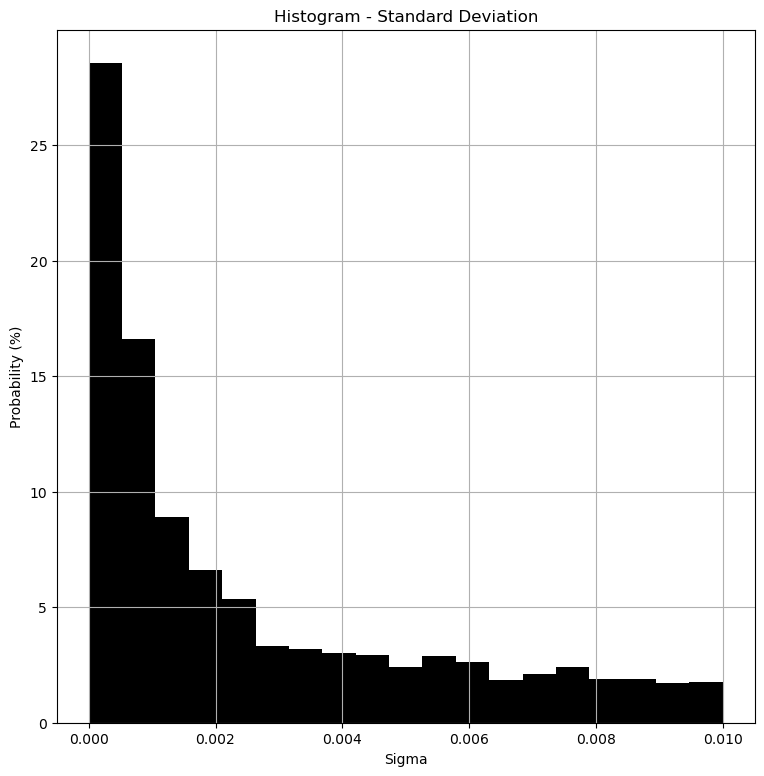

In [7]:
# Indexes where std_devs_Kepler<=0.01 (0.01 already done)
threshold = 0.01
index_kepler_std_threshold = np.where(std_devs_Kepler<=threshold)
index_kepler_std_threshold = np.asarray(list(index_kepler_std_threshold[0]))
index_kepler_std_threshold

# std_devs_Kepler<=0.01
print(std_devs_Kepler[index_kepler_std_threshold])


# Distribution of standard deviation
bins = np.linspace(0,threshold,20)

plt.figure(figsize=(9, 9))
# plt.hist(std_devs_Kepler, bins=bins, density=True, alpha=0.8, color='tab:green')
a,*_ = np.histogram(std_devs_Kepler[index_kepler_std_threshold], bins=bins)
print('a = ',a)
a_percent = (a/np.sum(a))*100
print('a_percent = ',a_percent)

plt.stairs(a_percent, bins, baseline=0,fill=True,color='black')
plt.xlabel('Sigma')
# plt.xscale("log")
plt.ylabel('Probability (%)')
plt.title('Histogram - Standard Deviation')
plt.grid(True)
plt.show()

In [15]:
# add noise with stddev < 0.01
# To training dataset
# Add noise to simulated train light curve, such that index is uniform

index_noise_train = np.random.choice(np.array(index_kepler_std_threshold),(len(train_lc_scaled_append),))
train_lc_scaled_append_noise = np.zeros(train_lc_scaled_append.shape)
print("index_noise_train.shape = ",index_noise_train.shape)
i = 0
for i in np.arange(len(train_lc_scaled_append)):
    index = int(index_noise_train[i])
    print(index)
    train_lc_scaled_append_noise[i] = train_lc_scaled_append[i] + noise_array[index]


# To Valdn dataset
# Add noise to simulated vald light curve, such that index is uniform
index_noise_vald= np.random.choice(np.array(index_kepler_std_threshold),(len(vald_lc_scaled_append),))
vald_lc_scaled_append_noise = np.zeros(vald_lc_scaled_append.shape)
print("index_noise_vald.shape = ",index_noise_vald.shape)
i = 0
for i in np.arange(len(vald_lc_scaled_append)):
    index = int(index_noise_vald[i])
    print(index)
    vald_lc_scaled_append_noise[i] = vald_lc_scaled_append[i] + noise_array[index]

index_noise_train.shape =  (132136,)
14398
13816
12708
1187
9836
1296
7399
12008
2584
10988
5691
15071
12203
6479
10760
14832
14811
103
7096
6704
9179
9551
9242
3300
15224
11028
14889
8649
147
11333
8986
10023
11879
9571
9994
9705
15651
7182
14277
487
1971
8420
1010
15301
13274
2221
10989
5905
6382
8055
8067
13285
15638
12398
14786
5718
952
15644
2135
374
2658
7201
13262
15635
1090
9087
13046
12
192
12006
9024
14011
9138
7632
9782
5851
9599
13818
9507
9056
12986
14678
7703
6061
1583
12293
11619
10970
9123
10159
11663
1999
11605
286
273
12461
4376
15608
6925
6359
2429
11859
4829
8575
4042
5307
9305
1587
6045
1024
4375
15396
9861
11394
14672
12782
8376
5279
12290
6996
12174
7786
168
1384
3287
15591
8148
9244
15301
7460
14377
4188
11247
745
868
4004
5044
1633
14049
3530
11599
13288
5454
5703
8315
11525
7610
862
2317
13818
2231
13548
9670
6252
6204
8088
2192
11332
7541
13684
1222
1803
4399
273
9581
5190
1090
10456
11869
7654
4210
5747
15012
3222
2742
6521
3882
12280
1583
10413
8218
9836
14

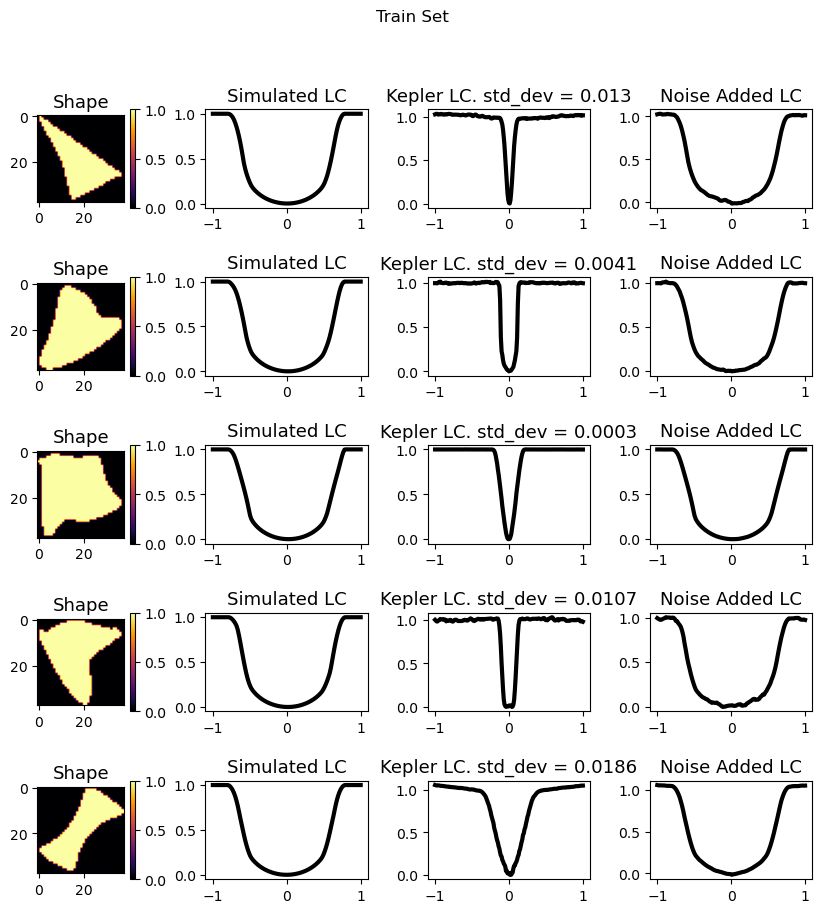

In [16]:
# Plot - Train LCs
num = 5
fig,ax=plt.subplots(num,4, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,3,3,3],
        'wspace': 0.4,'hspace': 0.7})

ph = np.linspace(-1,1,len(train_lc_scaled_append_noise[0]))
ph_kepler = np.linspace(-1,1,len(lc_np_array[0]))

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(train_lc_scaled_append_noise)-1)
    original_kelper_index = int(index_noise_train[int(k)])


    ax[i][0].set_title('Shape',size=13)
    img = ax[i][0].imshow(train_shape[k],cmap='inferno')
    plt.colorbar(img)

    ax[i][1].set_title('Simulated LC',size=13)
    ax[i][1].plot(ph, train_lc_scaled_append[k],color = 'black',linewidth='3')

    ax[i][2].set_title(f'Kepler LC. std_dev = {np.round(std_devs_Kepler[original_kelper_index],4)}',size=13)
    ax[i][2].plot(ph_kepler, lc_np_array[original_kelper_index]+1,color = 'black',linewidth='3')
    
    ax[i][3].set_title('Noise Added LC',size=13)
    ax[i][3].plot(ph, train_lc_scaled_append_noise[k],color = 'black',linewidth='3')

plt.suptitle("Train Set")

plt.show()


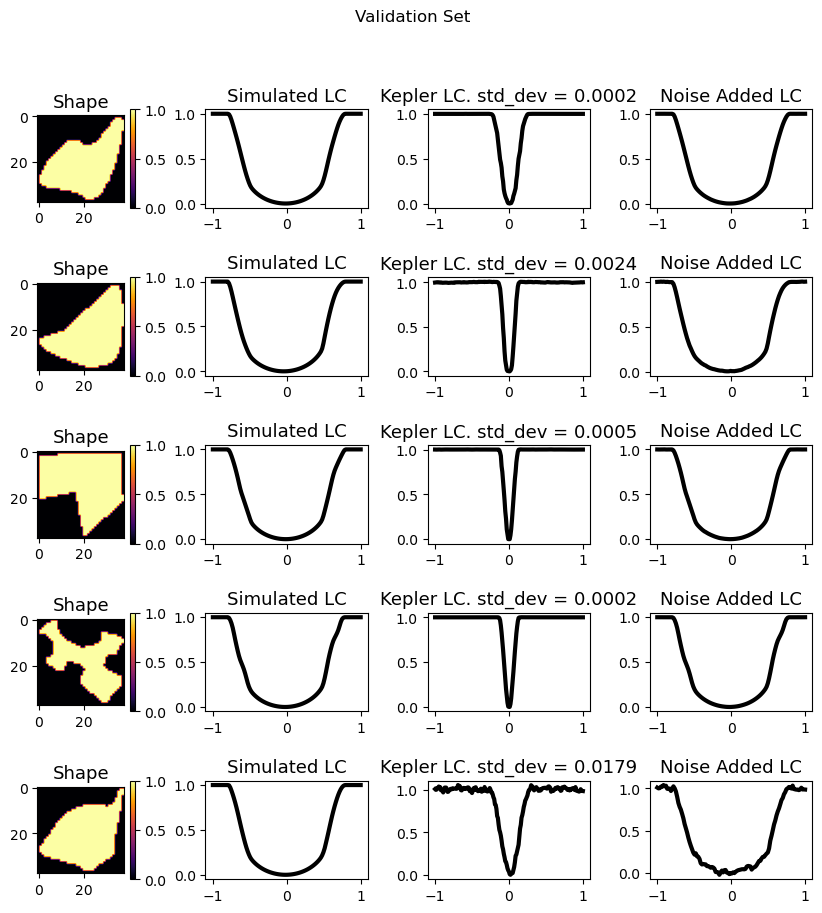

In [17]:
# Plot - Vald LCs
num = 5
fig,ax=plt.subplots(num,4, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,3,3,3],
        'wspace': 0.4,'hspace': 0.7})

ph = np.linspace(-1,1,len(vald_lc_scaled_append_noise[0]))
ph_kepler = np.linspace(-1,1,len(lc_np_array[0]))

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(vald_lc_scaled_append_noise)-1)
    original_kelper_index = int(index_noise_vald[int(k)])


    ax[i][0].set_title('Shape',size=13)
    img = ax[i][0].imshow(vald_shape[k],cmap='inferno')
    plt.colorbar(img)

    ax[i][1].set_title('Simulated LC',size=13)
    ax[i][1].plot(ph, vald_lc_scaled_append[k],color = 'black',linewidth='3')

    ax[i][2].set_title(f'Kepler LC. std_dev = {np.round(std_devs_Kepler[original_kelper_index],4)}',size=13)
    ax[i][2].plot(ph_kepler, lc_np_array[original_kelper_index]+1,color = 'black',linewidth='3')
    
    ax[i][3].set_title('Noise Added LC',size=13)
    ax[i][3].plot(ph, vald_lc_scaled_append_noise[k],color = 'black',linewidth='3')

plt.suptitle("Validation Set")
plt.show()


In [ ]:
# ML Pipeline
## Train Set
# train_dataset = tf.data.Dataset.from_tensor_slices((concat_train_lc,concat_train_shape))
train_dataset = tf.data.Dataset.from_tensor_slices((train_lc_scaled_append_noise,train_shape))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(len(train_dataset))
train_dataset = train_dataset.batch(100)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
print(train_dataset)

## Vald Set
# vald_dataset = tf.data.Dataset.from_tensor_slices((concat_vald_lc,concat_vald_shape))
vald_dataset = tf.data.Dataset.from_tensor_slices((vald_lc_scaled_append_noise,vald_shape))
vald_dataset = vald_dataset.batch(100)
vald_dataset = vald_dataset.cache()
vald_dataset = vald_dataset.prefetch(tf.data.AUTOTUNE)

print(vald_dataset)

In [18]:
# CNN Model
input_shape = np.array(np.shape(train_lc_scaled_append_noise[0]))
print("np.shape(input_shape) = ",input_shape[0])

output_shape = np.array(np.shape(train_shape[0]))
print("np.shape(input_shape) = ",output_shape[0],output_shape[1])

START = input_shape[0] # 94 #
END = output_shape[0] # 38  # pixel size along one axis
print("Start = ",START)
print("End = ",END)

conv_ip = keras.layers.Input(shape=(START,),name='Input')
x= keras.layers.Reshape((START, 1), input_shape=(START,),name='reshape_1')(conv_ip)
x= keras.layers.BatchNormalization()(x)

x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='conv16_5', padding='same')(x)
x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='second_conv16_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_1', padding='same')(x) #400

x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='first_conv32_5', padding='same')(x)
x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='second_conv32_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_2', padding='same')(x) #200

x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='first_conv64_5', padding='same')(x)
x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='second_conv64_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_3', padding='same')(x) #100

x=keras.layers.Flatten(name='flat_1')(x)

x2=keras.layers.Dense(256,name='dense_layer_5',activation='relu')(x)
x2=keras.layers.Dense(256,name='dense_layer_6',activation='relu')(x2)

x2= keras.layers.Dense(END**2,name='dense_layer_u',activation='relu')(x2)
x2 = keras.layers.Reshape(target_shape=(END, END, 1),name='reshape_2')(x2)

x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_52', padding='same')(x2)
x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_522', padding='same')(x2)
x2=keras.layers.Conv2D(16,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_524', padding='same')(x2)
x2=keras.layers.Conv2D(1,kernel_size=3,strides=1,activation='relu',name='second_conv64_53', padding='same')(x2)
conv_op = keras.layers.Reshape(target_shape=(END, END),name='reshape_3')(x2)
model = keras.Model(inputs=conv_ip, outputs=conv_op, name="predict_shape_from_LC")
model.summary()
print("Model is defined")

np.shape(input_shape) =  120
np.shape(input_shape) =  38 38
Start =  120
End =  38
Model: "predict_shape_from_LC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 120)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 120, 1)            0         
                                                                 
 batch_normalization (BatchN  (None, 120, 1)           4         
 ormalization)                                                   
                                                                 
 conv16_5 (Conv1D)           (None, 120, 16)           96        
                                                                 
 second_conv16_5 (Conv1D)    (None, 120, 16)           1296      
                                                                 
 maxpool_1 (MaxPooling1D)   

In [19]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
print("Model is compiled")

#Patience early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
print("Early stopping defined")

#Learning rate scheduler
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 20
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate
lr_sched = keras.callbacks.LearningRateScheduler(step_decay)
print("Learning rate scheduler defined")

Model is compiled
Early stopping defined
Learning rate scheduler defined


In [20]:
# Training 
print("Training will start now")
# history = model.fit(train_lc_scaled, train_shape, epochs=2000,verbose=2, validation_data=(vald_lc_scaled,vald_shape),callbacks=[es,lr_sched])
# history = model.fit(train_dataset, epochs=2000,verbose=2, validation_data=vald_dataset,callbacks=[es,lr_sched])
history = model.fit(train_lc_scaled_append_noise,train_shape, epochs=2000,verbose=2, validation_data=(vald_lc_scaled_append_noise,vald_shape),callbacks=[es,lr_sched])

# Save Model
save_model(model, "ml_saved_models/model_sep18_noise_0.02/model_sep18_v1_noise_lc.h5")

Training will start now


2023-09-18 10:00:10.719587: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 763217536 exceeds 10% of free system memory.
2023-09-18 10:00:21.695512: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 727.86MiB (rounded to 763217664)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-09-18 10:00:21.695655: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-09-18 10:00:21.695703: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 48, Chunks in use: 48. 12.0KiB allocated for chunks. 12.0KiB in use in bin. 1.4KiB client-requested in use in bin.
2023-09-18 10:00:21.695739: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.2K

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

next 27
2023-09-18 10:00:21.697010: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f5346001c00 of size 256 next 30
2023-09-18 10:00:21.697036: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f5346001d00 of size 256 next 33
2023-09-18 10:00:21.697060: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f5346001e00 of size 256 next 31
2023-09-18 10:00:21.697084: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f5346001f00 of size 256 next 32
2023-09-18 10:00:21.697107: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f5346002000 of size 256 next 36
2023-09-18 10:00:21.697131: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f5346002100 of size 256 next 37
2023-09-18 10:00:21.697155: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f5346002200 of size 256 next 40
2023-09-18 10:00:21.697180: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f5346002300 of size 1024 next 43
2023-09-18 10:00:21.697205: I t

In [63]:
# Validation dataset - Prediciton
model_load = load_model("ml_saved_models/model_sep15_noise/model_sep15_v1_noise_lc.h5")
vald_predict_shape = model_load.predict(vald_lc_scaled_append_noise)
vald_predict_shape_normalized = np.zeros(vald_predict_shape.shape)
for i in np.arange(len(vald_predict_shape)):
    vald_predict_shape_normalized[i] = (vald_predict_shape[i] - np.amin(vald_predict_shape[i]))/(np.amax(vald_predict_shape[i]) - np.amin(vald_predict_shape[i]))
print("Normalized the predicted shape")
vald_predict_shape = vald_predict_shape_normalized
del vald_predict_shape_normalized

32/32 [==============================] - 0s 5ms/step
Normalized the predicted shape


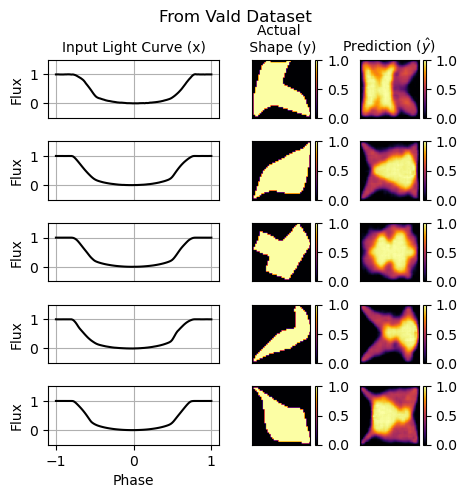

In [78]:

num = 5
fig,ax=plt.subplots(num,3, figsize=(5,5), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=10)
ax[0][0].set_title('Input Light Curve (x)',size=10)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=10)
ax[num-1][0].set_xlabel('Phase',size=10)
ph = np.linspace(-1.0,1.0,len(vald_lc_scaled_append_noise[0]))
# advance = 60
for i in range(num):
    k = random.randint(0, len(vald_lc_scaled_append_noise)-1)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(vald_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=10)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].plot(ph, vald_lc_scaled_append_noise[k],color = 'black')
    ax[i][0].grid('on')
    img = ax[i][2].imshow(vald_predict_shape[k],cmap='inferno')
    plt.colorbar(img)

plt.suptitle('From Vald Dataset')
plt.show()

# Test Dataset

test Set: No. of LC = No. of shapes
Extended the light curves


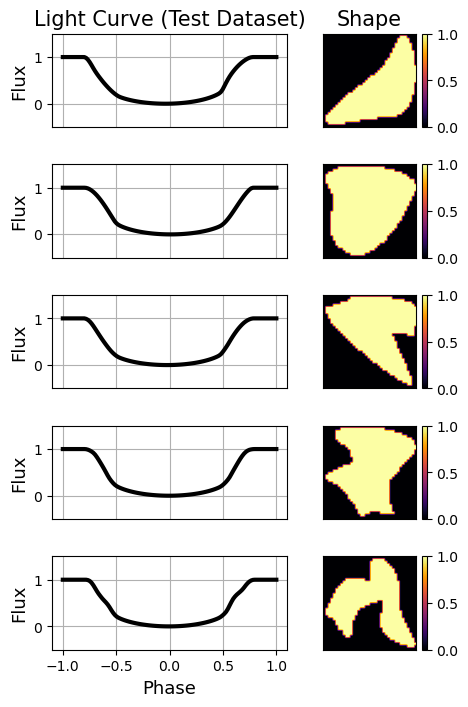

In [8]:
# Load Test Dataset
test_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled8.npy'
test_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_8.npy'
test_lc = np.load(test_lc_dir)
test_shape = np.load(test_shape_dir)
# Check equality of number of dataset
if len(test_lc)==len(test_shape):
    print("test Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: testn Set: No. of LC != No. of shapes")

# Normalize the image, convert to opacity map
## Test Set
test_shape = test_shape/np.amax(test_shape)
test_shape_where_0 = np.where(test_shape == 0)
test_shape_where_1 = np.where(test_shape == 1)
test_shape[test_shape_where_0] = 1  # 1 represent the shape (1 opacity)
test_shape[test_shape_where_1] = 0  # 0 represent background (0 opacity)


# Normalize the lightcurves
## - Test Set
test_lc_scaled = np.zeros(test_lc.shape)
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled[i] = (test_lc[i] - np.amin(test_lc[i]))/(np.amax(test_lc[i]) - np.amin(test_lc[i]))

# Append with ones
## - Test Set
test_lc_scaled_append = np.ones((test_lc.shape[0],120))
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled_append[i,10:110] = test_lc_scaled[i]
print("Extended the light curves")

# Verification
# Plot - Test LCs
num = 5
fig,ax=plt.subplots(num,2, figsize=(5,8), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (Test Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(test_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(test_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].plot(ph, test_lc_scaled_append[k],color = 'black',linewidth='3')
    ax[i][0].grid('on')
    i = i + 1


In [9]:
# Add Kepler Noise - Test Dataset
# Add noise to simulated test light curve, such that index is uniform
index_noise_test= np.random.choice(np.array(index_kepler_std_threshold),(len(test_lc_scaled_append),))
test_lc_scaled_append_noise = np.zeros(test_lc_scaled_append.shape)
print("index_noise_test.shape = ",index_noise_test.shape)
i = 0
for i in np.arange(len(test_lc_scaled_append)):
    index = int(index_noise_test[i])
    print(index)
    test_lc_scaled_append_noise[i] = test_lc_scaled_append[i] + noise_array[index]




index_noise_test.shape =  (250,)
10003
4369
1468
11492
1800
14905
552
14217
12470
263
2622
9396
4426
14687
3152
286
11787
10536
2286
152
10279
8760
4640
6521
58
8251
5289
14973
11857
3209
7495
1148
3284
11895
7173
9789
1922
6045
7654
533
8399
2939
12058
8175
11127
11580
2977
8419
7856
15551
9364
3226
15669
6485
2402
13018
868
12316
1566
12749
8320
7930
11763
13538
2135
312
6260
5601
15191
13376
2875
5320
14290
554
12858
9827
5617
9473
14278
13194
7023
405
14408
9867
12662
1164
13550
13376
3473
2928
1928
6734
9656
6551
14126
12461
1789
6045
6908
12392
2607
15175
2203
10978
5943
4042
14244
5840
14874
8067
8849
6881
5103
9121
2192
15332
9736
1459
14290
14494
14642
15651
1922
11473
1859
7105
11247
12912
7636
13846
10689
5454
11872
2773
6996
3538
387
12259
15691
10914
13285
15468
6081
5744
1940
9796
8760
2584
1608
4683
13411
14973
3348
2424
6343
14645
9705
2875
13274
6413
5376
6621
6318
5687
3355
10866
2875
12461
8901
12708
15022
10080
6909
12732
2607
384
226
9205
9203
7172
14318
583
58
776

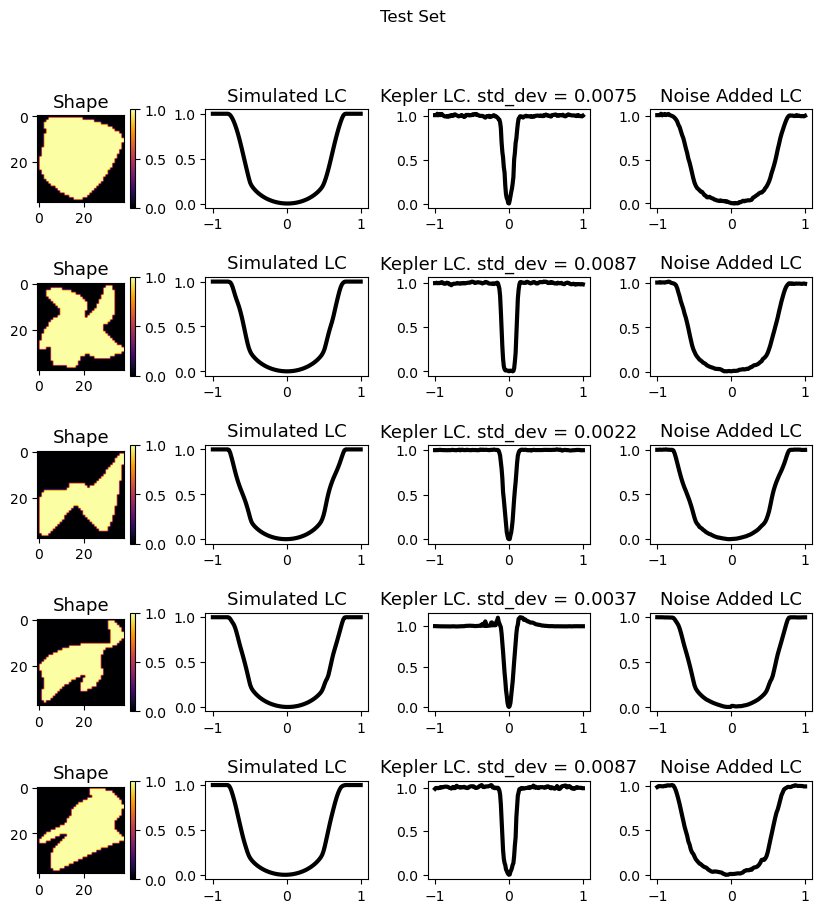

In [11]:
# Plot - Test LCs
num = 5
fig,ax=plt.subplots(num,4, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,3,3,3],
        'wspace': 0.4,'hspace': 0.7})

ph = np.linspace(-1,1,len(test_lc_scaled_append_noise[0]))
ph_kepler = np.linspace(-1,1,len(lc_np_array[0]))

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(test_lc_scaled_append_noise)-1)
    original_kelper_index = int(index_noise_test[int(k)])


    ax[i][0].set_title('Shape',size=13)
    img = ax[i][0].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)

    ax[i][1].set_title('Simulated LC',size=13)
    ax[i][1].plot(ph, test_lc_scaled_append[k],color = 'black',linewidth='3')

    ax[i][2].set_title(f'Kepler LC. std_dev = {np.round(std_devs_Kepler[original_kelper_index],4)}',size=13)
    ax[i][2].plot(ph_kepler, lc_np_array[original_kelper_index]+1,color = 'black',linewidth='3')
    
    ax[i][3].set_title('Noise Added LC',size=13)
    ax[i][3].plot(ph, test_lc_scaled_append_noise[k],color = 'black',linewidth='3')

plt.suptitle("Test Set")

plt.show()


In [12]:
# Test on the ML model - Test Dataset
# Test dataset - Prediciton
model_load = load_model("ml_saved_models/model_sep15_noise/model_sep15_v1_noise_lc.h5")
test_predict_shape = model_load.predict(test_lc_scaled_append_noise)
test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
for i in np.arange(len(test_predict_shape)):
    test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
print("Normalized the predicted shape")
test_predict_shape = test_predict_shape_normalized
del test_predict_shape_normalized

2023-09-19 14:57:59.163511: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


8/8 [==============================] - 3s 21ms/step
Normalized the predicted shape


In [15]:
results = model_load.evaluate(test_lc_scaled_append_noise, test_shape, batch_size=128)
results

2/2 [==============================] - 1s 324ms/step - loss: 0.1119


0.11190617084503174

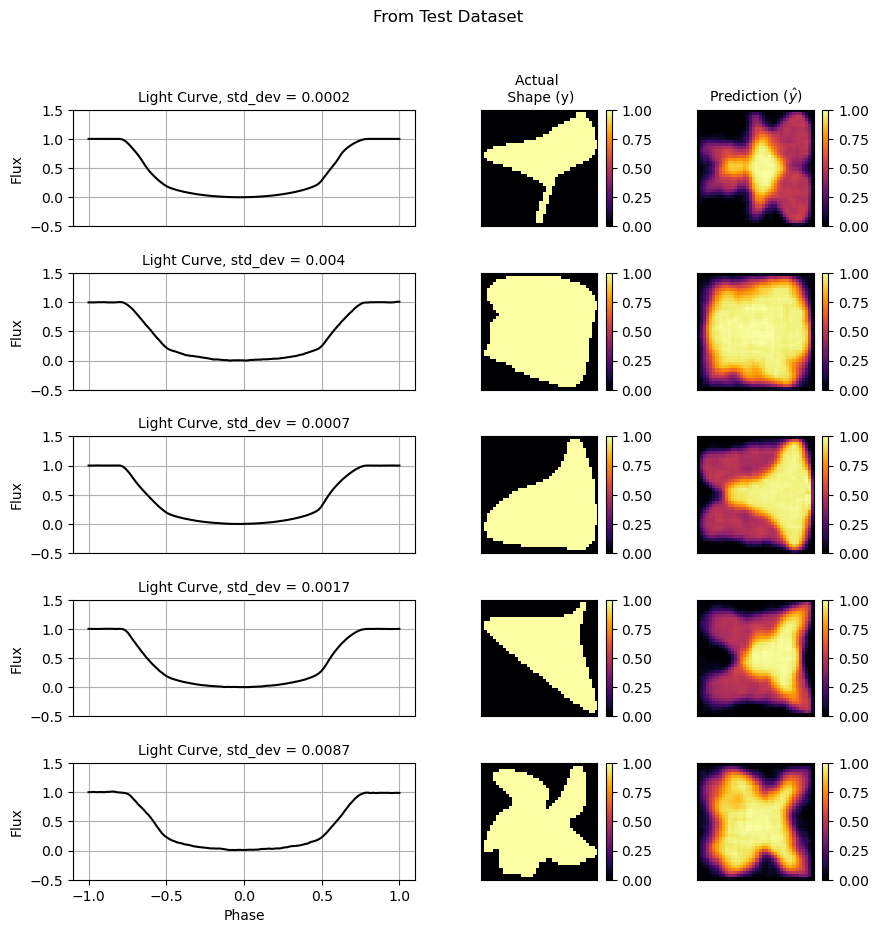

In [17]:

num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=10)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=10)
ax[num-1][0].set_xlabel('Phase',size=10)
ph = np.linspace(-1.0,1.0,len(test_lc_scaled_append_noise[0]))
# advance = 60
for i in range(num):
    k = random.randint(0, len(test_lc_scaled_append_noise)-1)
    original_kelper_index = int(index_noise_test[int(k)])
    
    ax[i][0].set_title(f'Light Curve, std_dev = {np.round(std_devs_Kepler[original_kelper_index],4)}',size=10)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=10)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].plot(ph, test_lc_scaled_append_noise[k],color = 'black')
    ax[i][0].grid('on')
    img = ax[i][2].imshow(test_predict_shape[k],cmap='inferno')
    plt.colorbar(img)

plt.suptitle('From Test Dataset')
plt.show()